In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/churn_data.csv')

In [3]:
#change dtype of 'TotalCharges' from object to numeric
#if there is an error, because the value has a space (" "), we use --> errors='coerce'
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [4]:
#getting null (missing) values
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [5]:
#set missing values to zero
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [6]:
#column names & string values: lowercasing everything and replace spaces with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes


In [8]:
#change target variable from object to integer (if yes, then 1; if no, then 0)
df.churn = (df.churn == 'yes').astype(int)

In [9]:
#splitting the dataset in different subsets
from sklearn.model_selection import train_test_split


In [10]:
#shuffling the data of df and splitting it into 2 sets
#df_train_full (80%), df_test(20%)
#random_state guarantees that the data is always shuffled in the same way
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [11]:
#take df_train_full and split it into train and val
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)
#save target variable in a matrix array
y_train = df_train.churn.values
y_val = df_val.churn.values
#delete target variable from training and validation set
del df_train['churn']
del df_val['churn']

<b>Feature Engineering</b><br>
We compare 3 scenarios:<br>
* Scenario 1: All features are included 
* Scenario 2: The two least important features 'gender' and 'phoneservice' are excluded
* Scenario 3: The most important feature 'contract' is exluded<br><br>
The cell below gives the accuracy for each Scenario


In [12]:
#create variable lists
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

categ_ex_1 = ['seniorcitizen', 'partner', 'dependents',
'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

categ_ex_2 = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

lists = [categorical, categ_ex_1, categ_ex_2]
scenario = ['Scenario 1:', 'Scenario 2:', 'Scenario 3:']

In [13]:
x = 0
for L in lists:
    def prepare_X(df, categ):
        #convert training set to dictionary
        train_dict = df[categ + numerical].to_dict(orient='rows')
        from sklearn.feature_extraction import DictVectorizer
        dv = DictVectorizer(sparse=False)
        dv.fit(train_dict)
        #use 'transform' method to convert dictionaries to matrix
        X = dv.transform(train_dict)
        return X
    
    #train logictic regression model
    from sklearn.linear_model import LogisticRegression
    #train model by calling the 'fit' method
    #X_train is derived from training set (besides we also have validation and testing set)
    model = LogisticRegression(solver='liblinear', random_state = 1)
    model.fit(prepare_X(df_train, L), y_train)
    
    def prepare_val(df, categ):
        #convert training set to dictionary
        train_dict = df[categ + numerical].to_dict(orient='rows')
        from sklearn.feature_extraction import DictVectorizer
        dv_new = DictVectorizer(sparse=False)
        dv_new.fit(train_dict)
        #use 'transform' method to convert dictionaries to matrix
        X = dv_new.transform(train_dict)
        return X
    
    #use the model to predict the target variable
    y_pred = model.predict_proba(prepare_val(df_val, L))[:, 1]
    y_pred >= 0.5
    churn = y_pred >= 0.5
    print('Accuracy for', scenario[x], (y_val == churn).mean())
    x += 1

Accuracy for Scenario 1: 0.8016129032258065
Accuracy for Scenario 2: 0.8026881720430108
Accuracy for Scenario 3: 0.7973118279569893


In [18]:
#take again all features in cosideration

def prepare_X(df):
    #convert training set to dictionary
    train_dict = df[categorical + numerical].to_dict(orient='rows')
    from sklearn.feature_extraction import DictVectorizer
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    #use 'transform' method to convert dictionaries to matrix
    X = dv.transform(train_dict)
    return X

#train logictic regression model
from sklearn.linear_model import LogisticRegression
#train model by calling the 'fit' method
#X_train is derived from training set (besides we also have validation and testing set)
model = LogisticRegression(solver='liblinear', random_state = 1)
model.fit(prepare_X(df_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
#take again all features in cosideration

def prepare_val(df_inp):
    #convert training set to dictionary
    train_dict = df_inp[categorical + numerical].to_dict(orient='rows')
    from sklearn.feature_extraction import DictVectorizer
    dv_new = DictVectorizer(sparse=False)
    dv_new.fit(train_dict)
    #use 'transform' method to convert dictionaries to matrix
    X = dv_new.transform(train_dict)
    return X

y_pred = model.predict_proba(prepare_val(df_val))[:, 1]


In [20]:
from sklearn.metrics import accuracy_score

In [21]:
#loop over different thresholds and see what has the best accuracy
#a threshold of 0.5 gives us the best accuracy
thresholds = np.linspace(0, 1, 11) #this gives 11 numbers starting with 0.0, 0.1, 0.2, ...
for t in thresholds:
    #compute accuracy
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    #print results
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


In [22]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)

Text(0, 0.5, 'Accurary')

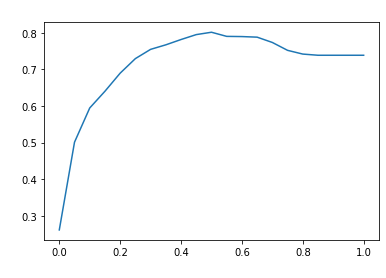

In [23]:
plt.plot(thresholds, accuracies)
plt.title('Threshold vs Accuracy', color='white')
plt.xlabel('Threshold', color='white')
plt.ylabel('Accurary', color='white')

Applying that to small model

In [24]:
small_subset = ['contract', 'tenure', 'totalcharges']
#convert to dictionary
train_dict_small = df_train[small_subset].to_dict(orient='rows')
#make use of DictVectorizer to perform one hot encoding
from sklearn.feature_extraction import DictVectorizer
dv_small = DictVectorizer(sparse=False)
#use fit method to apply DictVectorizer to dictionary
dv_small.fit(train_dict_small)
#transform dictionary to matrix array
X_small_train = dv_small.transform(train_dict_small)


In [25]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

#train a simpler model
#apply one-hot-encoding to validation set
val_dict_small = df_val[small_subset].to_dict(orient='rows')
dv_small.fit(val_dict_small)
X_small_val = dv_small.transform(val_dict_small)
#predict churn using this small model
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
churn_small = y_pred_small >= 0.5
#calculate accuracy
accuracy_score(y_val, churn_small)

0.7672043010752688

Is an accuracy of 0.77 now a good value? We need to compare it. One possibility could be<br>
the <b>Dummy Baseline</b>, what
* always predicts the majority class: here "no churn (False)"

In [26]:
#making a baseline prediction
#get number of customers in validation set
size_val = len(y_val)
#create array with only false elements
baseline = np.repeat(False, size_val)

In [27]:
#check the accuracy
accuracy_score(baseline, y_val)

0.7387096774193549

the smaller model is only 2% better and the big model is only 6% better than the dummy baseline.<br>
We need another metric: the <b>Confusion Table</b><br>
<img src="data/pic-9.png" width=600 align="left">

what the model is doing with the validation set:<br>
<img src="data/pic-10.png" width=400 align="left">

In [28]:
#calculate the 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


Generating 2 arrays out of the predicated target values:<br>
<img src="data/pic-11.png" width=600 align="left">

Generating 2 arrays out of the actual target values:<br>
<img src="data/pic-12.png" width=600 align="left">

In [29]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1202,  172],
       [ 197,  289]])

In [30]:
#take fractions to better understand the values
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

In [31]:
#produce confusion table out of the small table

#calculate the 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred_small >= t)
predict_no_churn = (y_pred_small < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


In [32]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1189,  185],
       [ 248,  238]])

In [33]:
#take fractions to better understand the values
confusion_table / confusion_table.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

<b>Precision and Recall</b><br>
metrics that help us to better understand the quality of the model<br>
in case of class imbalance.

<b>Precision</b>: How many of the positive predictions are correct<br>
* P = TP/(TP + FP)

<b>Recall</b>: Positive predictions divided by the number of all positive examples<br>
FN stands for a positive case, that was predicted negative<br>
* R = TP/(TP + FN)

<img src="data/pic-13.png" width=600 align="left">

* precision helps us to understand how many customers received promotional messages per mmistake (actually they are not going to churn)
* recall helps us to understand how many of the churning customers haven't been identified by the model

<b>ROC curve</b><br>
ROC stands of "receiver operating characteristics"<br>
It tells us how well a model can separate two classes.<br>
Here: churn and no churn<br>
2 metrics are required:<br> 
* FPR (false positive rate; look at 1st row of conf. table --> FP / (FP + TN)<br>
fraction of false postives among all negative examples<br>
!! The smaller the FPR, the better
* TPR (true positive rate; look at 2nd row of conf. table) --> TP / (TP + FN)<br>
fraction of true postives among all positive examples<br>
!! The higher the TPR, the better (same as recall)


<img src="data/pic-14.png" width=600 align="left">

<b>Evaluating a model at multiple thresholds</b>

In [34]:
#computing confusion table for different thresholds

#result list
scores = []
#create array with different threshold values
thresholds = np.linspace(0, 1, 101)

#compute confusion table for predictions at each threshold
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    #append results to scores list
    scores.append((t, tp, fp, fn, tn))


In [35]:
#convert list of tuples to dataframe
df_scores = pd.DataFrame(scores)
#give names to the columns
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [36]:
#[::10] selects every 10th record out of df
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [37]:
#compute tpr and fpr
#and add it to the df
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [38]:
#[::10] selects every 10th record out of df
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


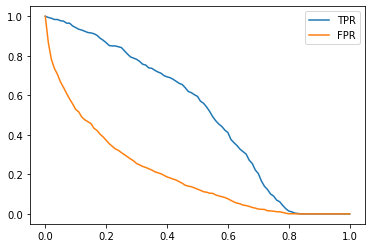

In [39]:
#plot the values
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.legend()

In [40]:
#get line, where difference between TPR and FPR is the biggest

#compute diff between tpr and fpr
#and add it to the df
df_scores['diff'] = df_scores.tpr - df_scores.fpr

In [41]:
#get row of df where diff is highest
df_scores.loc[df_scores['diff'] == df_scores['diff'].max()] 

,threshold,tp,fp,fn,tn,tpr,fpr,diff
25,0.25,409,426,77,948,0.841564,0.310044,0.53152


in order to better understand the meaning of TPR and FPR,<br>
we compare it with 2 baseline models (random model & ideal model)

<b>Random Baseline Model</b>

In [42]:
#fix random seed for reproducibility
np.random.seed(1)
#generate array with random numbers between 0 and 1
#y_rand contains the "predictions of our model"
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [43]:
#calculate TPR and FPR at different thresholds

#generate function what takes in actual and predicted values
def tpr_fpr_dataframe(y_val, y_pred):
    #calculate confusion table for different thresholds
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    
    #convert confusion table numbers to dataframe and give columns a name
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    
    #calculate TPR & FPR
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [44]:
#use the function to calculate TPR and FPR for random model
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [45]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


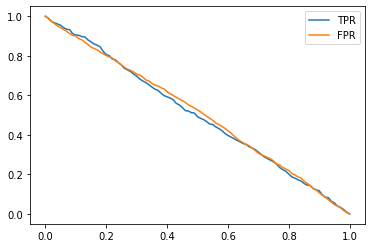

In [46]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()
#see also page 154 for explanation

<b>findings of random baseline model:</b>
* at threshold of 0.0, every is regarded as churning (the values of the target<br>
variable cannot be below 0 --> so TPR and FPR is 100%
* at threshold of 0.4, TPR and FPR are 60%<br>
for TPR: TP is 60%, FN is 40%<br>
for FPR: FP is 60%, TN is 40%
* at threshold of 1.0, everybody is regarded as non-churning<br>
so TPR and FPR are 0%<br>
for TPR: we have 0% TP and 100% FN<br>
for FPR: we have 0% FP and 100% TN

<b>The ideal (ranking) model</b><br>
That model always makes the right decisions.<br>
Churning customers always have higher scores than non-churning ones.<br>
--> predicted probability for all churned ones should be higher than predicted probabilty<br>
for non-churned ones

<img src="data/pic-15.png" width=400 align="left">

In [47]:
#generate ideal predictions
#generate array with fake target variables, that are already ordered
#it firstly only contains 0's, then it only contains 1's

#calculate number of negative and positive examples in dataset
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

#generate array that firstly repeates 0s num_neg number of times,
#then generates 1s repeated num_pos number of times
y_ideal = np.repeat([0,1], [num_neg, num_pos])

#generate "predicitions of the model"：numbers that grow 
#from 0 in first cell to 1 in last cell
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

#calculate TPR and FPR for this model
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)

In [48]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


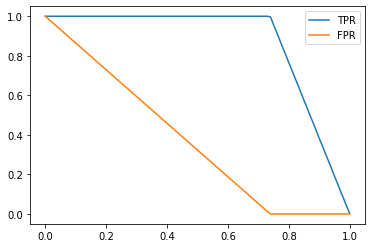

In [49]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label='FPR')
plt.legend()

<b>findings from above plot</b>
* for threshold lower than 0.74, the model always correctly classifies<br>
churning customers, that's why TPR stays at 100%
* on other side, we incorrectly classify non-churning customers as churning (FP),<br>
with a growing threshold, the FPR goes down (so fewer and fewer non-churning<br>
customers are predicted as churning
* at threshold of 0.74, we have ideal situation: all churning customers are<br>
are classified as churning (TPR = 100) and all non-churning customers <br>
are classified as non-churning (FPR = 0)
* above 0.74, we always correctly identify all non-churning customers<br>
(FPR stays at 0) but we incorrectly classify more and more churning customers<br>
as non-churning (TPR goes down)

<img src="data/pic-16.png" width=400 align="left">

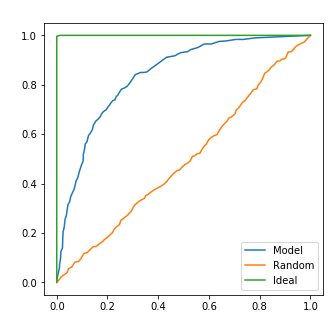

In [50]:
#create the ROC curve

#prepare plot square
plt.figure(figsize=(5, 5))
#plot ROC curve for the model
plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
#plot ROC curve for the random baseline model
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
#plot ROC curve for the ideal ranking model
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')

plt.legend()


<b>Findings from above plot:</b>
* in the upper left corner is our ideal spot (TPR = 100, FPR = 0)
* our curve should ideally reach this spot
* in upper right corner, the threshold is 0; in lower left corner, the threshold is 1 
* we can simplify the plot (see below)

Text(0.5, 1.0, 'ROC Curve')

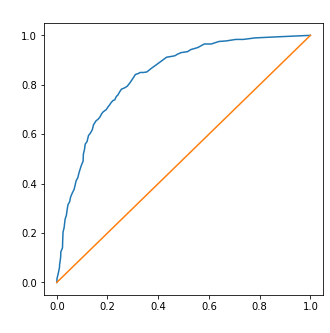

In [51]:
#prepare plot square
plt.figure(figsize=(5, 5))
#plot ROC curve for the model
plt.plot(df_scores.fpr, df_scores.tpr)
#draw a diagonal
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')


Text(0.5, 1.0, 'ROC Curve')

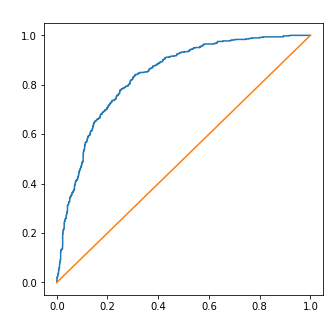

In [52]:
#use the roc_curve function to simplify your live
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('ROC Curve', color='white')




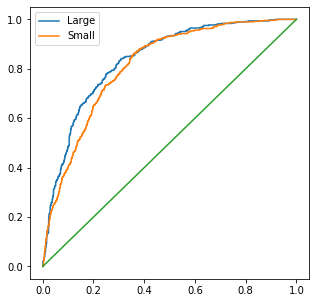

In [53]:
#compare performance (ROC curves) of of the large and small models
fpr_large, tpr_large, thresholds = roc_curve(y_val, y_pred)
fpr_small, tpr_small, thresholds = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(5, 5))

plt.plot(fpr_large, tpr_large, label='Large')
plt.plot(fpr_small, tpr_small, label='Small')
plt.plot([0, 1], [0, 1])
plt.legend()


<b>Area under the ROC curve (AUC</b>

In [54]:
from sklearn.metrics import auc
auc(df_scores.fpr, df_scores.tpr)

0.8359150837721111

In [55]:
#directly compute the AUC without the ROC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8363366398907399

In [56]:
#directly compute the AUC without the ROC
#for the small model
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_small)

0.8129399009230807

<b>findings from above</b>
* ROC curves and AUC scores tell us how well model separates positive from negative examples
* AUC also tells us the probability that the score (0 or 1) of randomly selected churning customer is higher (should be one)than the score of a randomly selected non-churning customer


<b>K-fold cross-validation</b>

<img src="data/pic-17.png" width=400 align="left">

In [57]:
#train the model
def train(df, y):
    #apply one-hot encoding
    cat = df[categorical + numerical].to_dict(orient='rows')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    X = dv.transform(cat)
    #train the model
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    
    return dv, model

In [58]:
#Apply the model to the new data
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='rows')
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [59]:
#K-fold cross-validation
from sklearn.model_selection import KFold
#split the data in 10 parts (k=10)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
#list for the results
aucs = []

#iterate over 10 different splits of the data
for train_idx, val_idx in kfold.split(df_train_full):
    #split data in train and validation sets
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    #train model and make predictions
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    #getting AUC
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

In [60]:
aucs

[0.8493392490816277,
 0.8413366336633662,
 0.8590269587894291,
 0.8330260883877869,
 0.8242555831265509,
 0.840959040959041,
 0.8437154021491371,
 0.8223355471220746,
 0.8450718838002075,
 0.8611811367685119]

In [61]:
#get mean and standard deviation
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


<b>findings from above:</b>
* the smaller the standard deviation, the more stable the model is
* a stable model is important, if we want to let it go live
* otherwise we would get some surprises

<b>Getting the best parameters</b>
* the model above used a default value for C, which controls level of regularization
* select cross-validation procedure for identification of best C

In [62]:
def train(df, y, C):
    cat = df[categorical + numerical].to_dict(orient='rows')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    X = dv.transform(cat)
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)
    
    return dv, model

In [63]:
nfolds = 10
kfold = KFold(n_splits = nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []
    for train_idx, val_idx in kfold.split(df_train_full):
        #split data in train and validation sets
        df_train = df_train_full.iloc[train_idx].reset_index(drop=True)
        df_val = df_train_full.iloc[val_idx].reset_index(drop=True)
        y_train = df_train.churn.values
        y_val = df_val.churn.values

        #train model and make predictions
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        #getting AUC
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.826 ± 0.016
C=0.01, auc = 0.841 ± 0.012
C=0.1, auc = 0.842 ± 0.012
C=0.5, auc = 0.842 ± 0.012
C=1, auc = 0.842 ± 0.012
C=10, auc = 0.842 ± 0.012


<b>Findings from above:</b>
* we should use that C, where auc is highest and std is smallest
* that applies to C = 0.5

In [64]:
#apply model on whole train and val set
#finally check it with test set

#create matrix arrays out of target variable
y_train = df_train_full.churn.values
y_test = df_test.churn.values

#train model on full training set
dv, model = train(df_train_full, y_train, C=0.5)
#pply it to test set
y_pred = predict(df_test, dv, model)

#evaluate predictions on test data
auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858
